## Import modules

In [2]:
import numpy as np
import open3d as o3d
from sklearn.ensemble import RandomForestClassifier
import pdal
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from plyfile import PlyData, PlyElement
import gc
from itertools import chain
from sklearn.metrics import confusion_matrix
import os
import joblib # Use to save model
from datetime import datetime, timezone
# from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from glob import glob
# from sklearn.model_selection import GridSearchCV
sns.set()

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [3]:
# ROOT_PLY = """/home/sspiegel/CapstoneData/Paris/Toronto_3D/L001.ply"""

## Load in features

In [4]:
ROOT = """/home/sspiegel/CapstoneData/Paris/training_10_classes/pickleFiles/radial/training/2025_12_01T03_53_Lille1_1_r_0_1_grid_0_02_features.npz"""
ROOT2 = """/home/sspiegel/CapstoneData/Paris/training_10_classes/pickleFiles/radial/training/2025_12_01T13_01_Lille1_1_r_0_2_grid_0_04_features.npz"""
ROOT3 = """/home/sspiegel/CapstoneData/Paris/training_10_classes/pickleFiles/radial/training/2025_12_02T00_07_Lille1_1_r_0_4_grid_0_08_features.npz"""
ROOT4 = """/home/sspiegel/CapstoneData/Paris/training_10_classes/pickleFiles/radial/training/2025_12_02T01_42_Lille1_1_r_0_8_grid_0_16_features.npz"""
ROOT5 = """/home/sspiegel/CapstoneData/Paris/training_10_classes/pickleFiles/radial/training/2025_12_02T02_15_Lille1_1_r_1_6_grid_0_32_features.npz"""
ROOT6 = """/home/sspiegel/CapstoneData/Paris/training_10_classes/pickleFiles/radial/training/2025_12_02T03_16_Lille1_1_r_3_2_grid_0_64_features.npz"""

In [5]:
fileList = [ROOT,ROOT2, ROOT3,ROOT4,ROOT5, ROOT6]
# fileList = [ROOT,ROOT2, ROOT3,ROOT4,ROOT5]

## Get computed features

In [6]:
das = [np.load(r)["array2"] for r in fileList]
das = np.hstack(das)

das = das.astype(np.float32)

# lastFi = np.load(fileList[-1], allow_pickle=True)["array2"]

# das = np.hstack((das, lastFi))

# xyz = np.load(fileList[0])["array1"]

cls = np.load(fileList[0])["array3"]

cls = cls.astype(np.int32)

In [7]:
das.dtype

dtype('float32')

In [8]:
# del lastFi
gc.collect()

77

## Load in points and labels

## Get columns

In [9]:
cols = ["EigenSum","omnivariance","entropy","linearity","planarity","sphericity","curvature","verticality1","verticality2","HeightVariance","HeightRange","count"]

In [10]:

ff = []

for i in range(1, len(fileList) + 1):
    col = [f"""{a}_radius{i}""" for a in cols]
    ff += col
        
    

In [11]:
allCols = ff + ['label']

In [12]:
allAtrs = np.hstack((das, cls.reshape(-1, 1)))

In [13]:
del das, cls

## Create dataframe

In [14]:
allAtrs = allAtrs.astype(np.float32)

In [15]:
total_dataframe = pd.DataFrame(allAtrs, columns=allCols).astype('float32')

total_dataframe["label"] = total_dataframe["label"].astype('int32')
for i in range(1, len(fileList) + 1):
    total_dataframe[f"""count_radius{i}"""] = total_dataframe[f"""count_radius{i}"""].astype('int32')
# total_dataframe["count_radius1"] = total_dataframe["count_radius1"].astype(int)
# total_dataframe["count_radius2"] = total_dataframe["count_radius2"].astype(int)

    
# total_dataframe["labelName"] = total_dataframe["label"].apply(labelPoints)

In [16]:
gc.collect()

0

In [18]:
# del allAtrs

In [19]:
# ss = ss[ss["count"] > 10]

In [20]:
# total_dataframe.head()

## Create PLY files with features (Only do if they don't already exist)

In [21]:
# for i in range(1, 7):
#     ls = [col for col in list(total_dataframe) if col.endswith(f"""radius{i}""")]
#     ls = ['X','Y','Z'] + ls + ['label']
#     partial_df = total_dataframe[ls]

#     tpsOut = []
#     for idx, tpe in partial_df.dtypes.to_dict().items():
#         if tpe == 'int64':
#             tpsOut.append((idx, 'i4'))
#         elif tpe == 'float64':
#             tpsOut.append((idx, 'f8'))
            
#     vertex_data = np.empty(allAtrs.shape[0], dtype=tpsOut)
    
#     for t in tpsOut:
#         vertex_data[t[0]] = partial_df[t[0]].values
    
        
#     el = PlyElement.describe(vertex_data, 'vertex')
    
#     # Create a PlyData object and write to a PLY file
#     # Set text=True for ASCII PLY, or text=False for binary PLY
#     PlyData([el], text=False).write(f"""/home/sspiegel/CapstoneData/Paris/Toronto_3D/PC_with_features/L002_features_radius{i}.ply""")

In [22]:
# total_dataframe = total_dataframe.query("label != 0") # We are not going to train on unclassified points
# total_dataframe = total_dataframe.copy()

## Load Random Forest classifier

In [23]:
# total_dataframe.head()

In [24]:
# total_dataframe.groupby("label").size() / total_dataframe.shape[0]

In [17]:
rf = RandomForestClassifier(verbose=1,n_jobs=16)

In [18]:
rf

,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [19]:
total_dataframe.reset_index(inplace = True)

In [20]:
# total_dataframe.head()

In [21]:
gc.collect()

0

In [22]:
maxAcc = 0.0

AccList = []

F1_ScoreList = []

AccDelta = 1e-4

difDelta = np.inf

# f1_score(y_true, y_pred, average='weighted')


randomState = 123
sampleSize = 2000

iters = 0


idsTrained = []

RemainTest = total_dataframe.copy()

while (difDelta >= AccDelta) and ( iters < 50):
    # print(sampleSize)
    print("""Starting iteration %d...""" % (iters + 1))
    TrainList = []
    idsList = []

    for i in range(1,10):
    #     if iters > 0: # Change sampling size after initial sample is given
    #         sampleSize = 1000
        print(f"""Label {i}""")
        SelectList = RemainTest.loc[RemainTest["label"] == i]
        if SelectList.shape[0] == 0:
            continue
        SelectList = SelectList.copy()
        trns = SelectList.sample(n = sampleSize, random_state = randomState, replace = True)
        idsList.append(trns.index.to_list())
        
        TrainList.append(trns)
    idsList = list(chain.from_iterable(idsList))
    idsTrained += idsList

    TrainList = total_dataframe.loc[idsTrained]

    # TrainList = pd.concat(TrainList)
    
    TrainList = TrainList.sample(frac = 1., random_state = randomState)
    
    TrainListX = TrainList[ff]
    TrainListY = TrainList["label"]
        
    rf.fit(TrainListX, TrainListY)
    
        
    RemainTestX = RemainTest[ff]
    RemainTestY = RemainTest["label"]
    
    RemainTest = RemainTest.loc[~RemainTest["index"].isin(idsTrained)]
    
    
    yPred = rf.predict(RemainTestX)
        
    RemainTestSample = RemainTest.sample(frac = 0.1, random_state=randomState)
    RemainTestSampleX = RemainTestSample[ff]
    RemainTestSampleY = RemainTestSample["label"]
    
    yPredSample = rf.predict(RemainTestSampleX)
    acc = (yPredSample==RemainTestSampleY).sum() / RemainTestSampleY.shape[0]

    print("""Current accuracy: %.4f""" % (100*acc))
    AccList.append(acc)
    f1 = f1_score(RemainTestSampleY, yPredSample,average = "weighted")

    difDelta = np.abs(maxAcc - f1)

    print("""\n\nCurrent f1 score: %.5f""" % f1)

    print("""\n\nCurrent f1 score delta: %.5f""" % difDelta)
    
    if acc > maxAcc:
        maxAcc = f1
    

    iters += 1

    # idsTrained += idsList  
    gc.collect()

print("""DONE!!!!""")   


Starting iteration 1...
Label 1
Label 2
Label 3
Label 4
Label 5
Label 6
Label 7
Label 8
Label 9


[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.6s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    1.9s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:   15.5s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:   55.1s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    2.0s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    6.1s finished


Current accuracy: 93.5023


Current f1 score: 0.93848


Current f1 score delta: 0.93848
Starting iteration 2...
Label 1
Label 2
Label 3
Label 4
Label 5
Label 6
Label 7
Label 8
Label 9


[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    1.1s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    3.6s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:   15.1s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:   56.3s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    2.1s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    6.8s finished


Current accuracy: 94.4218


Current f1 score: 0.94599


Current f1 score delta: 0.00751
Starting iteration 3...
Label 1
Label 2
Label 3
Label 4
Label 5
Label 6
Label 7
Label 8
Label 9


[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    1.9s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    5.9s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:   14.6s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:   56.8s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    2.0s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    6.4s finished


Current accuracy: 94.8333


Current f1 score: 0.94932


Current f1 score delta: 0.00333
Starting iteration 4...
Label 1
Label 2
Label 3
Label 4
Label 5
Label 6
Label 7
Label 8
Label 9


[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    2.4s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    8.2s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:   14.2s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:   56.4s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    2.1s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    6.7s finished


Current accuracy: 95.2209


Current f1 score: 0.95261


Current f1 score delta: 0.00329
Starting iteration 5...
Label 1
Label 2
Label 3
Label 4
Label 5
Label 6
Label 7
Label 8
Label 9


[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    3.1s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:   10.6s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:   15.4s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:   56.0s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    2.0s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    6.5s finished


Current accuracy: 95.6286


Current f1 score: 0.95612


Current f1 score delta: 0.00351
Starting iteration 6...
Label 1
Label 2
Label 3
Label 4
Label 5
Label 6
Label 7
Label 8
Label 9


[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    3.8s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:   13.2s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:   16.5s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:   57.1s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    2.1s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    6.8s finished


Current accuracy: 95.8111


Current f1 score: 0.95771


Current f1 score delta: 0.00159
Starting iteration 7...
Label 1
Label 2
Label 3
Label 4
Label 5
Label 6
Label 7
Label 8
Label 9


[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    4.5s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:   15.5s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:   16.5s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:   54.4s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    1.9s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    6.4s finished


Current accuracy: 96.0142


Current f1 score: 0.95947


Current f1 score delta: 0.00176
Starting iteration 8...
Label 1
Label 2
Label 3
Label 4
Label 5
Label 6
Label 7
Label 8
Label 9


[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    5.3s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:   17.7s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:   16.5s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:  1.0min finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    1.8s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    6.7s finished


Current accuracy: 96.1756


Current f1 score: 0.96091


Current f1 score delta: 0.00144
Starting iteration 9...
Label 1
Label 2
Label 3
Label 4
Label 5
Label 6
Label 7
Label 8
Label 9


[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    6.0s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:   20.5s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:   14.7s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:   50.8s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    1.7s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    6.6s finished


Current accuracy: 96.3102


Current f1 score: 0.96214


Current f1 score delta: 0.00123
Starting iteration 10...
Label 1
Label 2
Label 3
Label 4
Label 5
Label 6
Label 7
Label 8
Label 9


[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    6.8s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:   24.0s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:   15.9s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:   53.1s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    1.9s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    6.5s finished


Current accuracy: 96.4434


Current f1 score: 0.96336


Current f1 score delta: 0.00121
Starting iteration 11...
Label 1
Label 2
Label 3
Label 4
Label 5
Label 6
Label 7
Label 8
Label 9


[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    7.6s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:   26.5s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:   14.9s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:   50.7s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    2.0s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    6.9s finished


Current accuracy: 96.5384


Current f1 score: 0.96415


Current f1 score delta: 0.00080
Starting iteration 12...
Label 1
Label 2
Label 3
Label 4
Label 5
Label 6
Label 7
Label 8
Label 9


[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    8.2s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:   28.3s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:   15.2s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:   51.8s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    2.1s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    7.0s finished


Current accuracy: 96.6161


Current f1 score: 0.96483


Current f1 score delta: 0.00068
Starting iteration 13...
Label 1
Label 2
Label 3
Label 4
Label 5
Label 6
Label 7
Label 8
Label 9


[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    8.8s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:   30.4s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:   14.9s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:   51.4s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    2.0s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    7.0s finished


Current accuracy: 96.6871


Current f1 score: 0.96541


Current f1 score delta: 0.00058
Starting iteration 14...
Label 1
Label 2
Label 3
Label 4
Label 5
Label 6
Label 7
Label 8
Label 9


[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    9.6s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:   33.3s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:   14.6s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:   51.1s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    1.8s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    7.1s finished


Current accuracy: 96.7704


Current f1 score: 0.96626


Current f1 score delta: 0.00084
Starting iteration 15...
Label 1
Label 2
Label 3
Label 4
Label 5
Label 6
Label 7
Label 8
Label 9


[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:   10.1s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:   35.7s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:   17.0s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:   52.2s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    2.0s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    7.2s finished


Current accuracy: 96.8206


Current f1 score: 0.96668


Current f1 score delta: 0.00043
Starting iteration 16...
Label 1
Label 2
Label 3
Label 4
Label 5
Label 6
Label 7
Label 8
Label 9


[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:   10.9s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:   37.7s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:   15.2s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:   52.0s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    2.1s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    7.0s finished


Current accuracy: 96.8630


Current f1 score: 0.96707


Current f1 score delta: 0.00039
Starting iteration 17...
Label 1
Label 2
Label 3
Label 4
Label 5
Label 6
Label 7
Label 8
Label 9


[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:   11.7s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:   41.2s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:   14.8s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:   50.3s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    2.1s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    6.9s finished


Current accuracy: 96.9175


Current f1 score: 0.96753


Current f1 score delta: 0.00046
Starting iteration 18...
Label 1
Label 2
Label 3
Label 4
Label 5
Label 6
Label 7
Label 8
Label 9


[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:   12.9s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:   44.0s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:   15.3s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:   53.6s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    2.1s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    7.1s finished


Current accuracy: 96.9791


Current f1 score: 0.96806


Current f1 score delta: 0.00054
Starting iteration 19...
Label 1
Label 2
Label 3
Label 4
Label 5
Label 6
Label 7
Label 8
Label 9


[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:   13.0s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:   46.7s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:   15.2s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:   52.8s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    2.2s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    7.4s finished


Current accuracy: 97.0490


Current f1 score: 0.96875


Current f1 score delta: 0.00069
Starting iteration 20...
Label 1
Label 2
Label 3
Label 4
Label 5
Label 6
Label 7
Label 8
Label 9


[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:   14.1s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:   50.5s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:   15.3s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:   50.4s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    2.2s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    7.5s finished


Current accuracy: 97.1025


Current f1 score: 0.96920


Current f1 score delta: 0.00044
Starting iteration 21...
Label 1
Label 2
Label 3
Label 4
Label 5
Label 6
Label 7
Label 8
Label 9


[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:   14.8s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:   51.8s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:   15.0s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:   51.3s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    2.0s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    7.4s finished


Current accuracy: 97.1339


Current f1 score: 0.96950


Current f1 score delta: 0.00031
Starting iteration 22...
Label 1
Label 2
Label 3
Label 4
Label 5
Label 6
Label 7
Label 8
Label 9


[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:   15.7s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:   54.9s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:   15.3s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:   52.7s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    2.2s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    7.5s finished


Current accuracy: 97.1732


Current f1 score: 0.96986


Current f1 score delta: 0.00036
Starting iteration 23...
Label 1
Label 2
Label 3
Label 4
Label 5
Label 6
Label 7
Label 8
Label 9


[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:   16.9s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:   59.1s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:   15.1s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:   52.4s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    2.2s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    7.1s finished


Current accuracy: 97.2254


Current f1 score: 0.97037


Current f1 score delta: 0.00051
Starting iteration 24...
Label 1
Label 2
Label 3
Label 4
Label 5
Label 6
Label 7
Label 8
Label 9


[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:   17.5s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:  1.0min finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:   17.0s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:   52.2s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    2.0s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    7.5s finished


Current accuracy: 97.2223


Current f1 score: 0.97029


Current f1 score delta: 0.00009
DONE!!!!


In [23]:
gc.collect()

SelectList.shape

(2142913, 74)

## Plot iterations and accuracy

In [24]:
# plot_df = pd.DataFrame(data = {"F1 Score" : F1_ScoreList, "Overall Accuracy" : AccList})

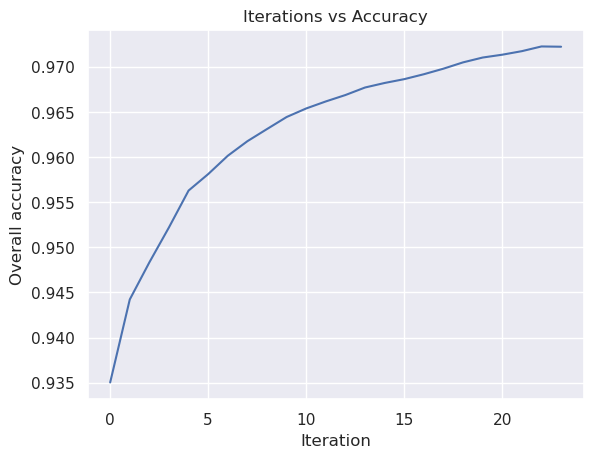

In [25]:
plt.plot(AccList)

plt.xlabel("Iteration")
plt.ylabel("Overall accuracy")

plt.title("Iterations vs Accuracy")

plt.show()


## Output model

In [26]:
OUTS = f"""{datetime.now().strftime("%Y_%m_%d")}_Trained_radial_RF_Lille_Height.joblib"""

joblib.dump(rf, f"""/home/sspiegel/CapstoneData/Paris/RF_models/{OUTS}""")

['/home/sspiegel/CapstoneData/Paris/RF_models/2025_12_02_Trained_radial_RF_Lille_Height.joblib']

In [27]:
importances = rf.feature_importances_

In [28]:
feature_importance_df = pd.DataFrame({'Feature': ff, 'Importance': importances})

In [29]:
feature_importance_df.sort_values("Importance", ascending = False).to_csv("""./results/radial_feature_importance.csv""", index = False)